In [6]:
import requests
import pandas as pd
from datetime import datetime, timedelta
from tqdm import tqdm
import matplotlib.pyplot as plt
import time
import os
import warnings
warnings.filterwarnings("ignore")

### DATA

In [5]:
os.chdir('../../db/')
os.getcwd()

'c:\\Users\\cwcha\\Desktop\\TS\\db'

In [2]:
twotci = pd.read_parquet("tw/ind/TWOTCI.parquet").iloc[:, :-1]
twotci['ticker'] = "TWOTCI"
twse = pd.read_parquet("tw/ind/TWSE.parquet")
twse['ticker'] = "TWSE"
df = pd.concat([twse, twotci], axis=0)

filtered_df = df.copy()
filtered_df['AvgPrice'] = (filtered_df['high'] + filtered_df['low']) / 2
filtered_df['Return'] = filtered_df.groupby('ticker')['AvgPrice'].pct_change()
filtered_df['beta'] = filtered_df.groupby('ticker')['close'].pct_change().shift(-1)
def rolling_std(group):
    group['return_stddev'] = group['Return'].rolling(window=5).std() * 100
    return group

filtered_df = filtered_df.groupby('ticker').apply(rolling_std).reset_index(level='ticker', drop=True)

def calculate_moving_averages(df):
    df['MA20'] = df['close'].rolling(window=20).mean()
    df['MA60'] = df['close'].rolling(window=60).mean()
    return df

filtered_df = filtered_df.groupby('ticker').apply(calculate_moving_averages).reset_index(level='ticker', drop=True)
start_date = '2015-01-01'
twse = filtered_df[(filtered_df['ticker'] == 'TWSE') & (filtered_df.index >= start_date)][['close', 'AvgPrice', "Return", "beta", "return_stddev", "MA20", "MA60"]]
twotci = filtered_df[(filtered_df['ticker'] == 'TWOTCI') & (filtered_df.index >= start_date)][['close', 'AvgPrice', "Return", "beta", "return_stddev", "MA20", "MA60"]]
twotci.reset_index(inplace=True)
twotci['da'] = pd.to_datetime(twotci['da'])
twse.reset_index(inplace=True)
twse['da'] = pd.to_datetime(twse['da'])

### Backtest start

In [3]:
import numpy as np
def calculate_twotci_metrics(row):
    date = row['da']
    twotci_today = twotci[twotci['da'] == date]
    twotci_next = twotci[twotci['da'] > date].sort_values(by='da').head(1)

    if not twotci_today.empty and not twotci_next.empty:
        twotci_beta = twotci_next['close'].values[0] / twotci_today['close'].values[0] - 1
    else:
        twotci_beta = np.nan
    
    twotci_return_stddev = twotci[(twotci['da'] >= (pd.to_datetime(date) - pd.Timedelta(days=5))) & (twotci['da'] <= date)]['Return'].std() * 100
    twotci_ma20 = twotci[twotci['da'] <= date].sort_values(by='da', ascending=False).head(20)['close'].mean()
    twotci_ma60 = twotci[twotci['da'] <= date].sort_values(by='da', ascending=False).head(60)['close'].mean()
    twotci_cl = twotci_today['close'].values[0] if not twotci_today.empty else np.nan
    
    return pd.Series([twotci_beta, twotci_return_stddev, twotci_ma20, twotci_ma60, twotci_cl])

final_df = twse.copy()
final_df[['TWOTCI_BETA', 'TWOTCI_RETURN_STDDEV', 'TWOTCI_MA20', 'TWOTCI_MA60', 'TWOTCI_CL']] = final_df.apply(calculate_twotci_metrics, axis=1)
final_df.set_index('da', inplace=True, drop=False)
final_df.columns


Index(['da', 'close', 'AvgPrice', 'Return', 'beta', 'return_stddev', 'MA20',
       'MA60', 'TWOTCI_BETA', 'TWOTCI_RETURN_STDDEV', 'TWOTCI_MA20',
       'TWOTCI_MA60', 'TWOTCI_CL'],
      dtype='object')

### Parameter Sensitivity Test

In [21]:
real_exposure = []
final_df['TWOTCI_RETURN_STDDEV_PREV'] = final_df['TWOTCI_RETURN_STDDEV'].shift(1)
for index, row in final_df.iterrows():
    if row['TWOTCI_RETURN_STDDEV'] <= 3 and row['TWOTCI_CL'] > row['TWOTCI_MA20']:
        real_exposure.append(1)
        print(str(index)+' '+str(row['TWOTCI_RETURN_STDDEV']) + " 1 " + str(row['TWOTCI_RETURN_STDDEV']-row['TWOTCI_RETURN_STDDEV_PREV']))
        flag = "波動牛📈"
        flag_singal = 1
    elif row['TWOTCI_RETURN_STDDEV'] <= 1 or row['return_stddev'] >= 3.5:
        real_exposure.append(1)
        print(str(index)+' '+str(row['TWOTCI_RETURN_STDDEV']) + " 1 " + str(row['TWOTCI_RETURN_STDDEV']-row['TWOTCI_RETURN_STDDEV_PREV']))
        flag = "穩定牛📈"
        flag_singal = 1
    elif (row['TWOTCI_RETURN_STDDEV']-row['TWOTCI_RETURN_STDDEV_PREV']) > 0.5 and row['TWOTCI_CL'] > row['TWOTCI_MA60'] and row['TWOTCI_CL'] < row['TWOTCI_MA20']:
        real_exposure.append(1)
        print(str(index)+' '+str(row['TWOTCI_RETURN_STDDEV']) + " 1 " + str(row['TWOTCI_RETURN_STDDEV']-row['TWOTCI_RETURN_STDDEV_PREV']))
        flag = "抄底牛📈"
        flag_singal = 1
    else:
        real_exposure.append(0)
        print(str(index)+' '+str(row['TWOTCI_RETURN_STDDEV']) + " 0 "+ str(row['TWOTCI_RETURN_STDDEV']-row['TWOTCI_RETURN_STDDEV_PREV']))
        flag = "害怕熊📉"
        flag_singal = 0
final_df['signal'] = real_exposure

2015-01-05 00:00:00 nan 0 nan
2015-01-06 00:00:00 0.7485820002131969 1 nan
2015-01-07 00:00:00 0.5749283336312598 1 -0.17365366658193704
2015-01-08 00:00:00 0.5926268728963238 1 0.01769853926506393
2015-01-09 00:00:00 0.5760341384124007 1 -0.016592734483923066
2015-01-12 00:00:00 0.49874700796017524 1 -0.07728713045222546
2015-01-13 00:00:00 0.31576771544689325 1 -0.182979292513282
2015-01-14 00:00:00 0.29396930196718407 1 -0.021798413479709178
2015-01-15 00:00:00 0.25391352097313286 1 -0.040055780994051216
2015-01-16 00:00:00 0.44532534205756313 1 0.19141182108443028
2015-01-19 00:00:00 0.5307768245903449 1 0.08545148253278179
2015-01-20 00:00:00 0.4645060911746773 1 -0.06627073341566764
2015-01-21 00:00:00 0.7234004544614321 1 0.2588943632867548
2015-01-22 00:00:00 0.5579291559837403 1 -0.16547129847769182
2015-01-23 00:00:00 0.5550835624168122 1 -0.0028455935669280397
2015-01-26 00:00:00 0.5480404174206887 1 -0.007043144996123574
2015-01-27 00:00:00 0.44308382172755917 1 -0.10495659

訊號做多後5天平均報酬: 0.004005318747686634 
訊號平倉後5天平均報酬: -0.009615769743669794


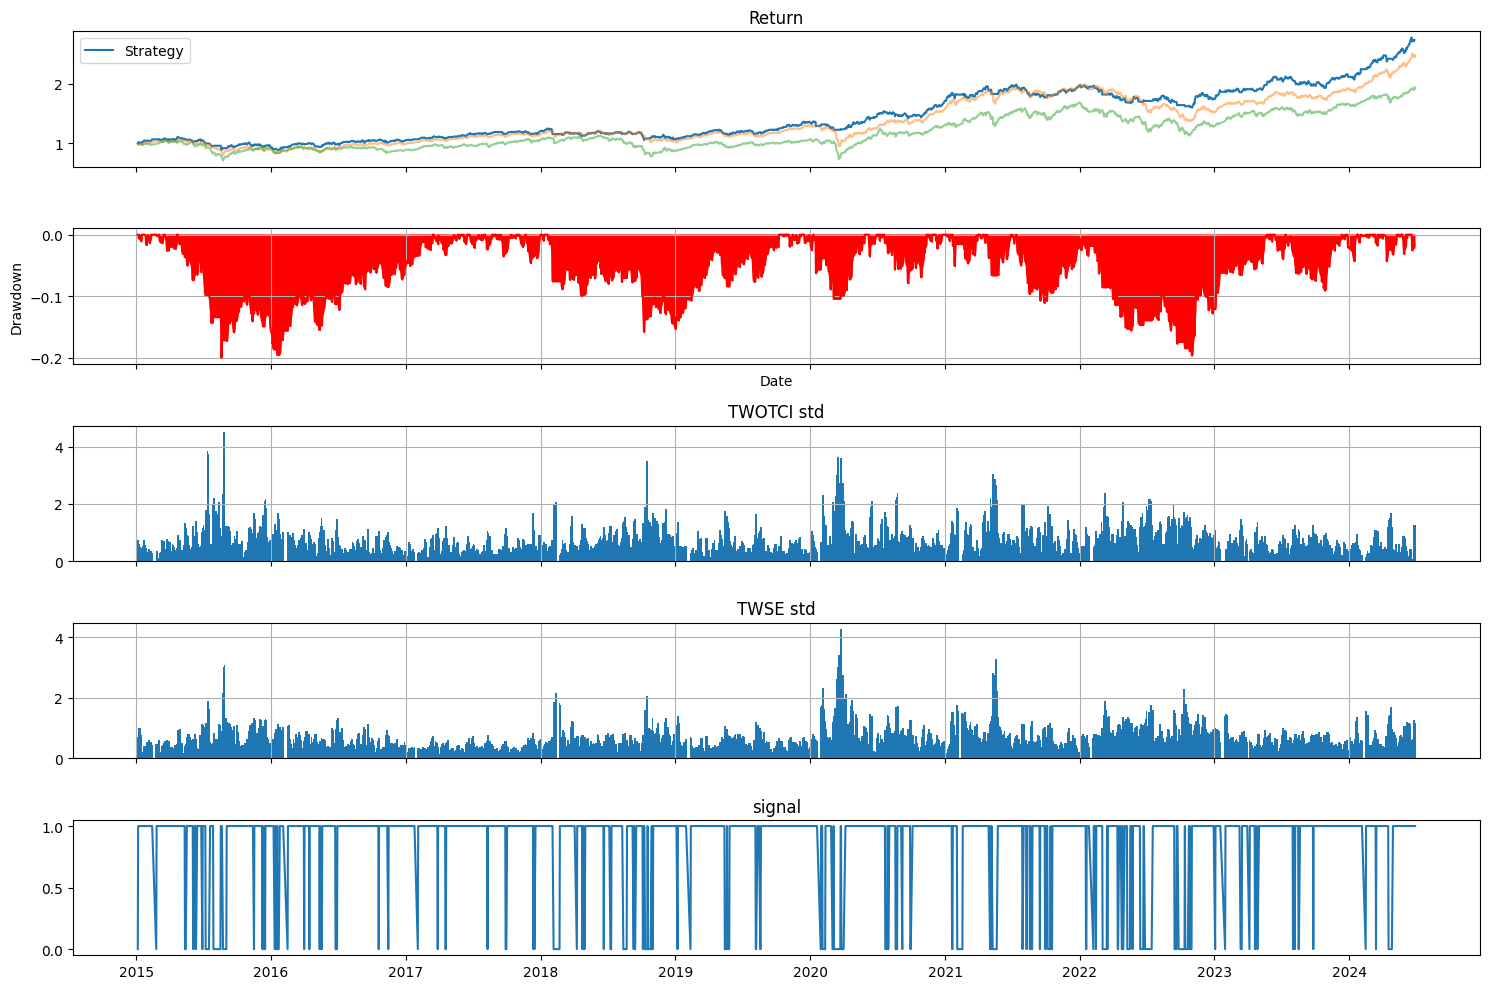

da
2024-06-24    2.731388
2024-06-25    2.721798
2024-06-26    2.736802
2024-06-27         NaN
2024-06-28         NaN
Name: cumprod_final_signal, dtype: float64

In [23]:
def calculate_return_on_signal(row, signal_col='final_signal'):
    return row['pct_change'] if row[signal_col] else 0

final_df['pct_change'] = final_df['close'].pct_change().shift(-2)

rolling = 5
final_df['check_if_signal_works'] = final_df['pct_change'].rolling(rolling).sum()
empty = final_df[final_df['signal'] == 0]['check_if_signal_works'].mean()
open = final_df[final_df['signal'] == 1]['check_if_signal_works'].mean()
print(f"訊號做多後{rolling}天平均報酬: {open} \n訊號平倉後{rolling}天平均報酬: {empty}")


final_df_da = final_df#[final_df['da'] >='2016-01-01']
final_df_da['daily_ret_final_signal'] = final_df_da.apply(calculate_return_on_signal, args=("signal",), axis=1)
final_df_da['cumprod_final_signal'] = (1+final_df_da['daily_ret_final_signal']).cumprod()

def from_nav_to_mdd(nav_all):
    Roll_Max = nav_all.rolling(len(nav_all), min_periods=1).max()
    Daily_Drawdown = nav_all/Roll_Max - 1.0
    return Daily_Drawdown
    
mdd = from_nav_to_mdd(final_df_da['cumprod_final_signal'])

fig, ax = plt.subplots(5, 1, figsize=(15, 10), sharex=True)
i = 0
ax[i].plot(final_df_da.index, final_df_da['cumprod_final_signal'], label='Strategy')
ax[i].plot(final_df_da.index, (1+final_df_da['Return']).cumprod(), alpha=0.5)
ax[i].plot(final_df_da.index, (1+final_df_da['TWOTCI_CL'].pct_change()).cumprod(), alpha=0.5)
ax[i].legend()
ax[i].set_title('Return')
i += 1

ax[i].plot(final_df_da.index,mdd, label='Maximum Drawdown', color='red')
ax[i].fill_between(final_df_da.index, mdd, color='red')
ax[i].set_ylabel('Drawdown')
ax[i].set_xlabel('Date')
ax[i].grid()
i += 1

ax[i].set_title("TWOTCI std")
ax[i].bar(final_df_da.index, final_df_da['TWOTCI_RETURN_STDDEV'],width=5)
ax[i].grid()
i += 1
ax[i].set_title("TWSE std")
ax[i].bar(final_df_da.index, final_df_da['return_stddev'], width=5)
ax[i].grid()
i += 1
ax[i].set_title("signal")
ax[i].plot(final_df_da['da'], final_df_da['signal'])

plt.tight_layout()
plt.show()
final_df_da['cumprod_final_signal'].tail()

In [ ]:
def calculate_return_on_signal(row, signal_col='final_signal'):
    return row['pct_change'] if row[signal_col] else 0
fig, ax = plt.subplots(1, 1, figsize=(20, 5), sharex=True)
for threshold in range(10, 30, 3):
    final_df['final_signal'] = (final_df['turbulence'] < threshold) & (final_df['TWOTCI_RETURN_STDDEV'] < 2)
    final_df['final_signal1'] = final_df['final_signal'].shift(1)
    final_df['final_signal2'] = final_df['final_signal'].shift(2)
    final_df['final_signal3'] = final_df['final_signal'].shift(3)
    final_df['final_signal4'] = final_df['final_signal'].shift(4)
    final_df['signals'] = (final_df['final_signal']) & (final_df['final_signal1']) & (final_df['final_signal2']) & (final_df['final_signal3']) & (final_df['final_signal4'])

    final_df['daily_ret_final_signal'] = final_df.apply(calculate_return_on_signal, args=("signals",), axis=1)
    final_df['cumprod_final_signal'] = (1+final_df['daily_ret_final_signal']).cumprod()
    print(threshold, final_df['cumprod_final_signal'].iloc[-3])
    ax.plot(final_df.index,final_df['cumprod_final_signal']-1, label=f"{threshold}")
ax.legend()
ax.set_title('diff for relative twotci threshold from 1 to 2 step 0.1')
plt.show()